In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet
from scarlet.display import AsinhMapping
from scarlet.source import StarletSource

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, display_rgb, SEG_CMAP
from kuaizi.detection import Data

import sep

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.convolution import convolve, Gaussian2DKernel

plt.rcParams['font.size'] = 15
plt.rc('image', cmap='inferno', interpolation='none', origin='lower')


Bad key savefig.frameon in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc

In [5]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

In [6]:
lsbg_cat = Table.read('./Cutout/Candy/candy_cutout_cat.fits')
lsbg = lsbg_cat[101]

In [7]:
lsbg

ra,dec,a_image,b_image,theta_image,ellipticity,mag_auto_g,mag_auto_r,mag_auto_i,flux_radius_ave_g,flux_radius_ave_i,mu_ave_g,mu_ave_i,acorr_ratio,g-i,g-r,A_g,A_r,A_i,tract,patch,synth_id,viz-id,objectid,Seq,cutout_size,prefix,radius,image_flag [5],psf_flag [5]
,,,,,,,,,,,,,,,,,,,,,,,,,arcmin,,arcmin,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes3,int64,int64,int64,int64,float64,bytes54,float64,bool,bool
192.2391581,-0.7822447,56.355,24.601,-59.05,0.563,18.792,18.1947,17.9135,12.003096,12.788496,25.58502843922785,24.88059069607654,1.0674875327349216,0.7626410334222635,0.5198352024303944,0.08671028720013609,0.061445489630532556,0.04385132062240102,9356,"6,4",-1,88143,88143,101,1.0,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_101,1.0,True .. True,True .. True


In [27]:
with open(f"./Model/candy-{lsbg['Seq']}-trained-model-wavelet.df", "rb") as fp:
    blend, info, mask = dill.load(fp)
    fp.close()

In [28]:
observation = blend.observations[0]
_blend = scarlet.Blend([blend.sources[0]], observation)
models = _blend.get_model()
weights = observation.weights
psfs = observation.psf.get_model()
mask = mask | (weights.sum(axis=0) == 0)
print(info)

{'starlet_thresh': 0.5, 'e_rel': 1e-06, 'loss': -2263730.0256600156, 'sed_ind': array([0])}


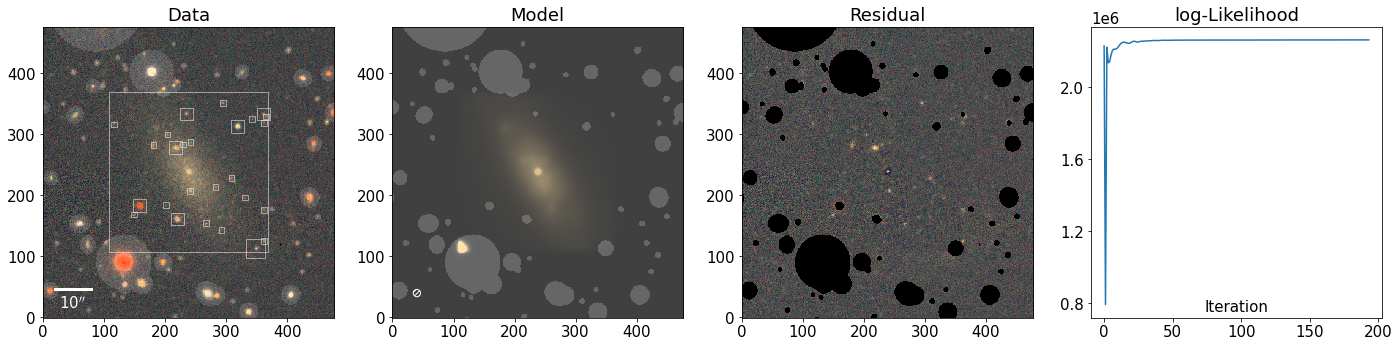

In [30]:
fig = kz.display.display_scarlet_results_tigress(
            blend,
            mask,
            show_ind=[0],
            zoomin_size=80,
            minimum=-0.3,
            stretch=1,
            Q=1,
            channels=observation.channels,
            show_loss=True,
            show_mask=False,
            show_mark=False,
            scale_bar=True)

In [34]:
filt = 2
img = models[filt]

rms = sep.Background(observation.data[2], mask=mask).globalrms

_, segmap = sep.extract(img, 1, err=rms, mask=mask, segmentation_map=True)

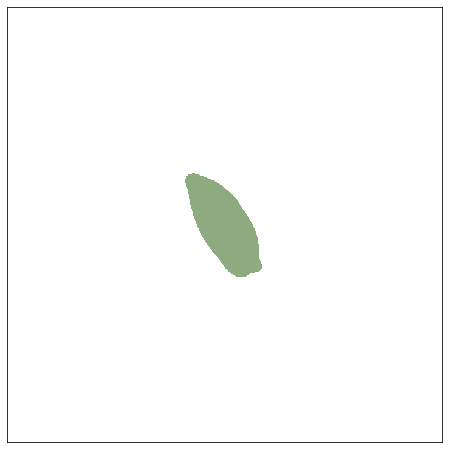

In [35]:
display_single(segmap.astype(float), cmap=SEG_CMAP, scale='linear');

In [212]:
# Measure morph

In [205]:
with open(f"./Model/candy-{lsbg['Seq']}-trained-model-wavelet.df", "rb") as fp:
    blend, info, aggr_mask = dill.load(fp)
    fp.close()
observation = blend.observations[0]

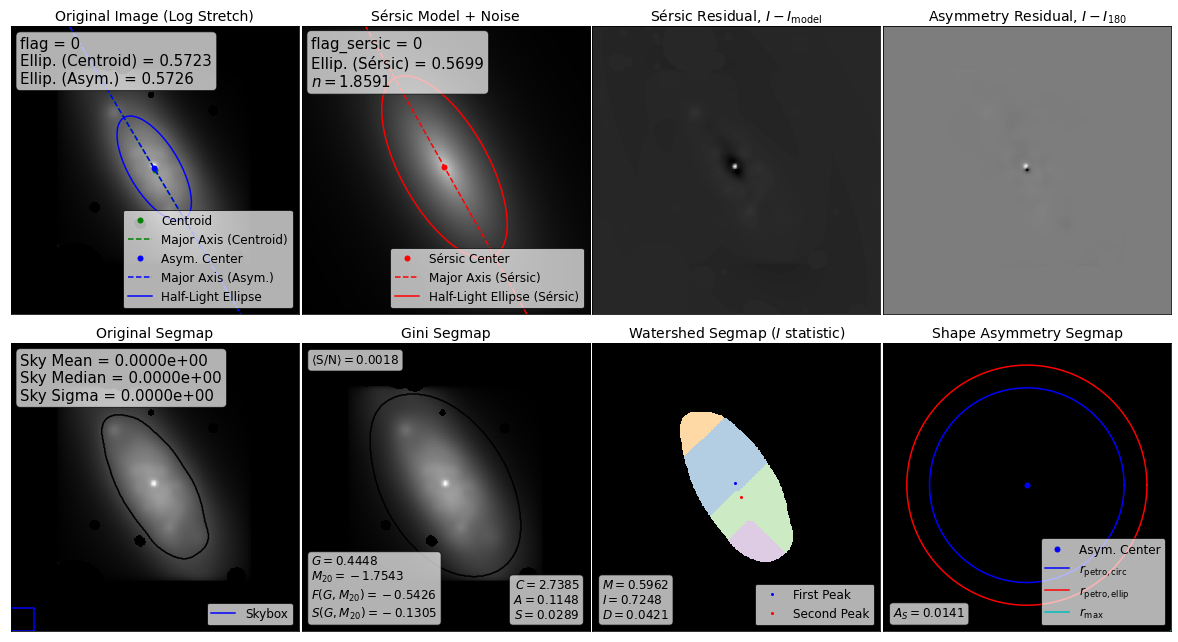

In [207]:
measurement, morph = kz.measure.makeMeasurement(blend.sources[:1], observation, aggr_mask=aggr_mask, 
                                         zeropoint=27.0, out_prefix=None, 
                                         show_fig=True, asinh_a=0.02, framealpha=0.7)

In [209]:
-2.5 * np.log10(measurement['SB_0_circ'] / (0.168**2)) + 27.0

array([23.0206  , 22.470886, 22.21742 , 22.12163 ], dtype=float32)

In [210]:
-2.5 * np.log10(measurement['SB_eff_circ'] / (0.168**2)) + 27.0

array([26.367598, 25.817884, 25.564419, 25.468628], dtype=float32)

In [211]:
-2.5 * np.log10(measurement['SB_eff_ellip'] / (0.168**2)) + 27.0

array([26.122242, 25.572529, 25.319063, 25.22327 ], dtype=float32)

In [45]:
### Surface brightness

In [58]:
import photutils

In [90]:
image = morph._cutout_stamp_maskzeroed
r = morph.rhalf_circ
r_in = r - 0.5 * morph._annulus_width
r_out = r + 0.5 * morph._annulus_width

center = morph._asymmetry_center

circ_annulus = photutils.CircularAnnulus(center, r_in, r_out)

In [91]:
circ_annulus

<CircularAnnulus([171.849924  , 170.35016515], r_in=54.434000639315535, r_out=55.434000639315535)>

In [97]:
circ_annulus.do_photometry(image, method='exact')[0][0] / _aperture_area(circ_annulus, morph._mask_stamp)

0.10588904779862689

In [83]:
from statmorph.statmorph import _aperture_area

In [111]:
morph.SB_eff_ellip

0.1326720991633661

In [101]:
morph.SB_circ(30)

0.2309987992763701

In [102]:
morph.SB_circ(54)

0.1088485801924251

In [ ]:
## Central SB

In [169]:
image = morph._cutout_stamp_maskzeroed
center = morph._peak


In [176]:
SB_set = []
r_set = np.logspace(-1, 1, 25)
for r in r_set: 
    #r = 1 #morph.rhalf_circ
    circ_aper = photutils.CircularAperture(center, r)
    SB_set.append(circ_aper.do_photometry(image)[0][0] / circ_aper.area)

In [184]:
morph.SB_circ(1)

1.455276766395422

In [187]:
morph.SB_0_circ

array(2.31020329)

In [186]:
morph.SB_0_ellip

array(2.31018508)

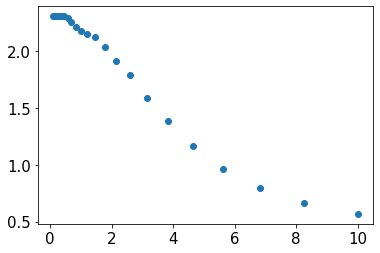

In [172]:
plt.scatter(np.logspace(-1, 1, 25), SB_set)

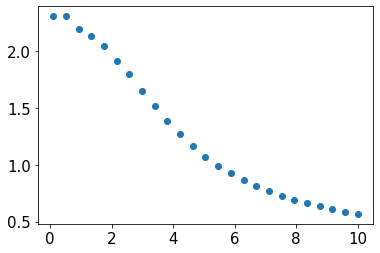

In [174]:
plt.scatter(np.linspace(0.1, 10, 25), SB_set)

In [191]:
from kuaizi import old_measure

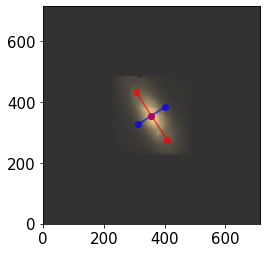

In [193]:
temp = old_measure.makeMeasurement(blend.sources[:1], observation, show_fig=True)

In [194]:
temp

{'x_cen': 356.64375168299165,
 'y_cen': 354.828377799406,
 'ra_cen': 192.23917417411988,
 'dec_cen': -0.7823414415960165,
 'x_cen_winpos': 357.55937458888684,
 'y_cen_winpos': 353.7215505902157,
 'ra_cen_winpos': 192.23913144106703,
 'dec_cen_winpos': -0.7823930935323838,
 'flux': array([1842.1173, 3056.3464, 3860.015 , 4216.0483], dtype=float32),
 'mag': array([18.836708, 18.286995, 18.033527, 17.937737], dtype=float32),
 'R50': array([11.73221851, 11.73221914, 11.73221971, 11.7322193 ]),
 'q': array([0.55651472, 0.55651472, 0.55651472, 0.55651472]),
 'pa': array([-56.94883183, -56.94883183, -56.94883184, -56.94883183]),
 'SB0': array([23.972975, 23.423262, 23.169796, 23.074005], dtype=float32),
 'SB0_winpos': array([24.399937, 23.850224, 23.596756, 23.500965], dtype=float32)}

In [197]:
-2.5 * np.log10(morph.SB_0_ellip / (0.168**2)) + 27.0

22.217429472498406

In [196]:
morph.SB_0_circ

array(2.31020329)